In [1]:
import os
import pandas as pd
import math
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
print("imports successful")

imports successful


In [2]:
df = pd.read_csv('data_cleaned/housing_imputed.csv')
col_df = pd.read_csv('data_cleaned/wages_cleaned.csv')

In [3]:
df.head(5)

,status,price,bed,bath,acre_lot,full_address,street,city,state,zip_code,house_size,sold_date
0,for_sale,110000.0,7.0,3.0,0.09,"B-2 Monte Elena, Dorado, PR, 00949",B-2 Monte Elena,Dorado,Puerto Rico,949.0,1192.0,2019-06-28
1,for_sale,950000.0,5.0,4.0,0.99,"46 Water Isle, Saint Thomas, VI, 00802",46 Water Isle,Saint Thomas,Virgin Islands,802.0,5000.0,2013-10-11
2,for_sale,6899000.0,4.0,6.0,0.83,"10 Water Isle, Saint Thomas, VI, 00802",10 Water Isle,Saint Thomas,Virgin Islands,802.0,4600.0,2018-04-05
3,for_sale,525000.0,3.0,3.0,0.45,"955 River Rd, Agawam, MA, 01001",955 River Rd,Agawam,Massachusetts,1001.0,2314.0,2014-06-25
4,for_sale,289900.0,3.0,2.0,0.36,"82 Harvey Johnson Dr, Agawam, MA, 01001",82 Harvey Johnson Dr,Agawam,Massachusetts,1001.0,1276.0,2012-10-12


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42768 entries, 0 to 42767
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   status        42768 non-null  object 
 1   price         42768 non-null  float64
 2   bed           42768 non-null  float64
 3   bath          42768 non-null  float64
 4   acre_lot      42768 non-null  float64
 5   full_address  42768 non-null  object 
 6   street        42699 non-null  object 
 7   city          42768 non-null  object 
 8   state         42768 non-null  object 
 9   zip_code      42768 non-null  float64
 10  house_size    42768 non-null  float64
 11  sold_date     42768 non-null  object 
dtypes: float64(6), object(6)
memory usage: 3.9+ MB


In [5]:
lookup = {
    "AL": "Alabama",
    "AK": "Alaska",
    "AZ": "Arizona",
    "AR": "Arkansas",
    "CA": "California",
    "CO": "Colorado",
    "CT": "Connecticut",
    "DE": "Delaware",
    "FL": "Florida",
    "GA": "Georgia",
    "HI": "Hawaii",
    "ID": "Idaho",
    "IL": "Illinois",
    "IN": "Indiana",
    "IA": "Iowa",
    "KS": "Kansas",
    "KY": "Kentucky",
    "LA": "Louisiana",
    "ME": "Maine",
    "MD": "Maryland",
    "MA": "Massachusetts",
    "MI": "Michigan",
    "MN": "Minnesota",
    "MS": "Mississippi",
    "MO": "Missouri",
    "MT": "Montana",
    "NE": "Nebraska",
    "NV": "Nevada",
    "NH": "New Hampshire",
    "NJ": "New Jersey",
    "NM": "New Mexico",
    "NY": "New York",
    "NC": "North Carolina",
    "ND": "North Dakota",
    "OH": "Ohio",
    "OK": "Oklahoma",
    "OR": "Oregon",
    "PA": "Pennsylvania",
    "PR": "Puerto Rico",
    "VI": "Virgin Islands",
    "RI": "Rhode Island",
    "SC": "South Carolina",
    "SD": "South Dakota",
    "TN": "Tennessee",
    "TX": "Texas",
    "UT": "Utah",
    "VT": "Vermont",
    "VA": "Virginia",
    "WA": "Washington",
    "WV": "West Virginia",
    "WI": "Wisconsin",
    "WY": "Wyoming"
}

col_df['state'] = col_df['state'].map(lookup)
col_df.head(5)

,area,state,a_median,a_pct10,a_pct25,a_pct75,a_pct90
0,Abilene,Texas,47096.596491,31627.017544,38100.035088,58140.526316,70476.007067
1,Aguadilla-Isabela,Puerto Rico,28787.163462,20556.538462,23760.721154,36941.634615,45111.062802
2,Akron,Ohio,54828.518519,36269.141104,44119.549180,67639.004149,80155.063291
3,Albany,Georgia,46217.944664,30135.494071,36429.090909,57225.458167,69350.607287
4,Albany,Oregon,52356.785714,37517.984190,44254.466403,62871.388889,74747.429719


### The annual median age did not include data for Virgin Islands. We only have 2 entries, so we will drop these values:

In [6]:
print(len(df[(df['state'] == 'Virgin Islands')]))
print(f'before drop: {len(df)}')
df = df[~(df['state'] == 'Virgin Islands')]
print(f'after drop: {len(df)}')

2
before drop: 42768
after drop: 42766


In [7]:
med_by_state = col_df.groupby(by='state').mean()
med_by_state.reset_index(inplace=True)
med_by_state = med_by_state.rename(columns = {'index':'state'})
med_by_state.head()

,state,a_median,a_pct10,a_pct25,a_pct75,a_pct90
0,Alabama,48019.703877,32423.777166,39188.233187,59024.009912,70552.578890
1,Alaska,64067.490421,43340.588504,52063.120027,77282.842952,91256.586809
2,Arizona,51404.169756,37130.575654,42972.203945,62770.724525,75762.974646
3,Arkansas,45544.732349,31953.005907,37583.285322,56299.974806,66947.085328
4,California,62562.178685,42646.072352,50880.943825,76465.309817,89692.249255


In [8]:
df = df.merge(col_df.drop(['state'], axis=1), left_on='city', right_on='area', how='left').drop('area', axis=1)
df = df.merge(med_by_state, left_on='state', right_on='state', how='left')
df.head()

,status,price,bed,bath,acre_lot,full_address,street,city,state,zip_code,...,a_median_x,a_pct10_x,a_pct25_x,a_pct75_x,a_pct90_x,a_median_y,a_pct10_y,a_pct25_y,a_pct75_y,a_pct90_y
0,for_sale,110000.0,7.0,3.0,0.09,"B-2 Monte Elena, Dorado, PR, 00949",B-2 Monte Elena,Dorado,Puerto Rico,949.0,...,NaN,NaN,NaN,NaN,NaN,28320.251592,20332.837304,23609.153506,35825.463335,45573.280489
1,for_sale,525000.0,3.0,3.0,0.45,"955 River Rd, Agawam, MA, 01001",955 River Rd,Agawam,Massachusetts,1001.0,...,NaN,NaN,NaN,NaN,NaN,61535.725466,42612.219815,50551.673128,75039.496723,88808.477027
2,for_sale,289900.0,3.0,2.0,0.36,"82 Harvey Johnson Dr, Agawam, MA, 01001",82 Harvey Johnson Dr,Agawam,Massachusetts,1001.0,...,NaN,NaN,NaN,NaN,NaN,61535.725466,42612.219815,50551.673128,75039.496723,88808.477027
3,for_sale,384900.0,3.0,2.0,0.46,"45 Hampden Ln, Agawam, MA, 01001",45 Hampden Ln,Agawam,Massachusetts,1001.0,...,NaN,NaN,NaN,NaN,NaN,61535.725466,42612.219815,50551.673128,75039.496723,88808.477027
4,for_sale,199999.0,3.0,2.0,1.76,"88 South St, Agawam, MA, 01001",88 South St,Agawam,Massachusetts,1001.0,...,NaN,NaN,NaN,NaN,NaN,61535.725466,42612.219815,50551.673128,75039.496723,88808.477027


### Now we merge the columns, taking cost of statistic_x where city matched up, or statistic_y if city cost of living is Na

In [9]:
def mask_col(orig_df, col_name, suffix_1, suffix_2):
    df = orig_df.copy()
    
    # mask the NA of col _x with value _y where missing, otherwise take _x as value
    new_vals = df[f'{col_name}_{suffix_1}'].mask(df[f'{col_name}_{suffix_1}'].isna(), df[f'{col_name}_{suffix_2}'])
    
    # supply values as unpacked dict so it uses the variable col_name as the column name, rather than the literal 'col_name'
    df = df.assign(**{col_name: new_vals})
    df = df.drop([f'{col_name}_{suffix_1}', f'{col_name}_{suffix_2}'], axis=1)
    return df
    
df = mask_col(df, 'a_median', 'x', 'y')
df = mask_col(df, 'a_pct10', 'x', 'y')
df = mask_col(df, 'a_pct25', 'x', 'y')
df = mask_col(df, 'a_pct75', 'x', 'y')
df = mask_col(df, 'a_pct90', 'x', 'y')
# df = df.assign(annual_median=df['annual_median_x'].mask(df['annual_median_x'].isna(), df['annual_median_y']))
# df = df.drop(['annual_median_x', 'annual_median_y'], axis=1)
df.head(5)

,status,price,bed,bath,acre_lot,full_address,street,city,state,zip_code,house_size,sold_date,a_median,a_pct10,a_pct25,a_pct75,a_pct90
0,for_sale,110000.0,7.0,3.0,0.09,"B-2 Monte Elena, Dorado, PR, 00949",B-2 Monte Elena,Dorado,Puerto Rico,949.0,1192.0,2019-06-28,28320.251592,20332.837304,23609.153506,35825.463335,45573.280489
1,for_sale,525000.0,3.0,3.0,0.45,"955 River Rd, Agawam, MA, 01001",955 River Rd,Agawam,Massachusetts,1001.0,2314.0,2014-06-25,61535.725466,42612.219815,50551.673128,75039.496723,88808.477027
2,for_sale,289900.0,3.0,2.0,0.36,"82 Harvey Johnson Dr, Agawam, MA, 01001",82 Harvey Johnson Dr,Agawam,Massachusetts,1001.0,1276.0,2012-10-12,61535.725466,42612.219815,50551.673128,75039.496723,88808.477027
3,for_sale,384900.0,3.0,2.0,0.46,"45 Hampden Ln, Agawam, MA, 01001",45 Hampden Ln,Agawam,Massachusetts,1001.0,1476.0,1986-11-20,61535.725466,42612.219815,50551.673128,75039.496723,88808.477027
4,for_sale,199999.0,3.0,2.0,1.76,"88 South St, Agawam, MA, 01001",88 South St,Agawam,Massachusetts,1001.0,1968.0,2008-09-19,61535.725466,42612.219815,50551.673128,75039.496723,88808.477027


In [10]:
# ensure we filled all values
print(df['a_median'].isna().any())
print(df['a_pct10'].isna().any())
print(df['a_pct25'].isna().any())
print(df['a_pct75'].isna().any())
print(df['a_pct90'].isna().any())

False
False
False
False
False


In [11]:
df.dtypes

status           object
price           float64
bed             float64
bath            float64
acre_lot        float64
full_address     object
street           object
city             object
state            object
zip_code        float64
house_size      float64
sold_date        object
a_median        float64
a_pct10         float64
a_pct25         float64
a_pct75         float64
a_pct90         float64
dtype: object

## 1. Make sure columns are correct types
sold_date is a date not an object

In [12]:
df['sold_date'] = pd.to_datetime(df['sold_date'])
# dropped_df['sold_date'] = pd.to_datetime(dropped_df['sold_date'])

df.dtypes

status                  object
price                  float64
bed                    float64
bath                   float64
acre_lot               float64
full_address            object
street                  object
city                    object
state                   object
zip_code               float64
house_size             float64
sold_date       datetime64[ns]
a_median               float64
a_pct10                float64
a_pct25                float64
a_pct75                float64
a_pct90                float64
dtype: object

In [13]:
df['sold_date'].head(5)

0   2019-06-28
1   2014-06-25
2   2012-10-12
3   1986-11-20
4   2008-09-19
Name: sold_date, dtype: datetime64[ns]

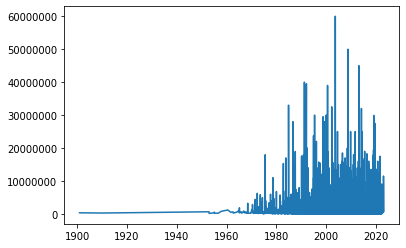

In [14]:
def plot_line(df, xfeat, yfeat):
    df = df.sort_values(by=xfeat)
    fig, ax = plt.subplots()
    ax.plot(df[xfeat], df[yfeat])
    ax.ticklabel_format(axis='y', style='plain')
    plt.show()
    
plot_line(df, 'sold_date', 'price')
# lp = sns.lineplot(data=df, x='sold_date', y='price')

In [15]:
df[df['price'] > 100000000]

,status,price,bed,bath,acre_lot,full_address,street,city,state,zip_code,house_size,sold_date,a_median,a_pct10,a_pct25,a_pct75,a_pct90


## 2. Price outliers
Drop these outliers as it is vastly outside the average

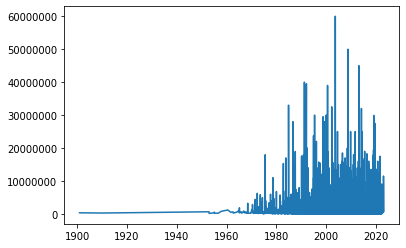

In [16]:
df = df[df['price'] < 100000000]
plot_line(df, 'sold_date', 'price')

### Now convert datetime to a timestamp so we can use it for predictions

In [17]:
df['sold_date'] = df['sold_date'].apply(lambda x: x.timestamp())
# dropped_df['sold_date'] = dropped_df['sold_date'].apply(lambda x: x.timestamp())
df.head(5)

,status,price,bed,bath,acre_lot,full_address,street,city,state,zip_code,house_size,sold_date,a_median,a_pct10,a_pct25,a_pct75,a_pct90
0,for_sale,110000.0,7.0,3.0,0.09,"B-2 Monte Elena, Dorado, PR, 00949",B-2 Monte Elena,Dorado,Puerto Rico,949.0,1192.0,1.561680e+09,28320.251592,20332.837304,23609.153506,35825.463335,45573.280489
1,for_sale,525000.0,3.0,3.0,0.45,"955 River Rd, Agawam, MA, 01001",955 River Rd,Agawam,Massachusetts,1001.0,2314.0,1.403654e+09,61535.725466,42612.219815,50551.673128,75039.496723,88808.477027
2,for_sale,289900.0,3.0,2.0,0.36,"82 Harvey Johnson Dr, Agawam, MA, 01001",82 Harvey Johnson Dr,Agawam,Massachusetts,1001.0,1276.0,1.350000e+09,61535.725466,42612.219815,50551.673128,75039.496723,88808.477027
3,for_sale,384900.0,3.0,2.0,0.46,"45 Hampden Ln, Agawam, MA, 01001",45 Hampden Ln,Agawam,Massachusetts,1001.0,1476.0,5.328288e+08,61535.725466,42612.219815,50551.673128,75039.496723,88808.477027
4,for_sale,199999.0,3.0,2.0,1.76,"88 South St, Agawam, MA, 01001",88 South St,Agawam,Massachusetts,1001.0,1968.0,1.221782e+09,61535.725466,42612.219815,50551.673128,75039.496723,88808.477027


## 3. Drop unused features
We will drop Street and full_address as they are distinct and will not likely help with predictions. Sold date might be a useful feature for us since the housing prices change over time.

In [18]:
df = df.drop(['street', 'full_address', 'status'], axis=1)

In [19]:
df = df.dropna(subset=['acre_lot'])

In [20]:
df.head(5)

,price,bed,bath,acre_lot,city,state,zip_code,house_size,sold_date,a_median,a_pct10,a_pct25,a_pct75,a_pct90
0,110000.0,7.0,3.0,0.09,Dorado,Puerto Rico,949.0,1192.0,1.561680e+09,28320.251592,20332.837304,23609.153506,35825.463335,45573.280489
1,525000.0,3.0,3.0,0.45,Agawam,Massachusetts,1001.0,2314.0,1.403654e+09,61535.725466,42612.219815,50551.673128,75039.496723,88808.477027
2,289900.0,3.0,2.0,0.36,Agawam,Massachusetts,1001.0,1276.0,1.350000e+09,61535.725466,42612.219815,50551.673128,75039.496723,88808.477027
3,384900.0,3.0,2.0,0.46,Agawam,Massachusetts,1001.0,1476.0,5.328288e+08,61535.725466,42612.219815,50551.673128,75039.496723,88808.477027
4,199999.0,3.0,2.0,1.76,Agawam,Massachusetts,1001.0,1968.0,1.221782e+09,61535.725466,42612.219815,50551.673128,75039.496723,88808.477027


### Add new features that relate the bed/bath to the house size

In [21]:
# df = df.assign(['beds_per_sqft'] 
# df = df.assign(baths_per_bed = (df['bath'] / df['bed']))
# df.head()

In [22]:
len(df['state'].unique())

11

In [23]:
len(df['zip_code'].unique())

2436

In [24]:
df[df['zip_code'] == 0]

,price,bed,bath,acre_lot,city,state,zip_code,house_size,sold_date,a_median,a_pct10,a_pct25,a_pct75,a_pct90


In [25]:
df[df['zip_code'].isna()]

,price,bed,bath,acre_lot,city,state,zip_code,house_size,sold_date,a_median,a_pct10,a_pct25,a_pct75,a_pct90


## 4. Hash Features
Since zip_code has no na, and is more informative than city and state, we will drop city and state and used a featurehasher to engineer features form zip_code. We will create another DF where we use the state as a one-hot encoded vector since there are only 13 states

### Since there are 2470of unique cities, one hot encoding would add too many features. Instead we will apply feature hashing to a fixed length set of features

In [26]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction import FeatureHasher

def hash_feature(df, feature, num_features):    
    print(f'Hashing feature "{feature}" to {num_features} features.')
    
    fh = FeatureHasher(n_features=num_features, input_type='string')
    feature_hashes = fh.fit_transform(df[feature])
    as_arr = feature_hashes.toarray()
    
    # reset index on df so that our concatenation works
    orig_df = df.reset_index(drop=True)
    orig_df = pd.concat([orig_df, pd.DataFrame(as_arr, columns=[f'{feature}{i}' for i in range(1, num_features+1)])], axis=1)
    orig_df = orig_df.drop(feature, axis=1)
   
    return orig_df

def freq_feature(df, features):
    new_df = df.copy()
    
    for feature in features:
        freq_map = df[feature].value_counts().to_dict()
        new_df[feature] = new_df[feature].map(freq_map)
        
    return new_df

# df = df.drop(['sold_date'], axis=1)
    
hashed_df_sal = df.drop(['city', 'state'], axis=1)
hashed_df_sal['zip_code'] = hashed_df_sal['zip_code'].astype(str)
hashed_df_sal = hash_feature(hashed_df_sal, 'zip_code', 25)

freq_df_sal = freq_feature(df, ['state', 'city', 'zip_code'])

# Keep a copy with and without added median salary information to see which performs better
hashed_df = hashed_df_sal.drop(['a_median', 'a_pct10', 'a_pct25', 'a_pct75', 'a_pct90'], axis=1)
freq_df = freq_df_sal.drop(['a_median', 'a_pct10', 'a_pct25', 'a_pct75', 'a_pct90'], axis=1)

Hashing feature "zip_code" to 25 features.


In [27]:
hashed_df.head(3)

,price,bed,bath,acre_lot,house_size,sold_date,zip_code1,zip_code2,zip_code3,zip_code4,...,zip_code16,zip_code17,zip_code18,zip_code19,zip_code20,zip_code21,zip_code22,zip_code23,zip_code24,zip_code25
0,110000.0,7.0,3.0,0.09,1192.0,1.561680e+09,0.0,0.0,0.0,-1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,-1.0,0.0,0.0
1,525000.0,3.0,3.0,0.45,2314.0,1.403654e+09,0.0,0.0,0.0,-1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,289900.0,3.0,2.0,0.36,1276.0,1.350000e+09,0.0,0.0,0.0,-1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [28]:
freq_df.head(3)

,price,bed,bath,acre_lot,city,state,zip_code,house_size,sold_date
0,110000.0,7.0,3.0,0.09,1,1,1,1192.0,1.561680e+09
1,525000.0,3.0,3.0,0.45,8,3307,4,2314.0,1.403654e+09
2,289900.0,3.0,2.0,0.36,8,3307,4,1276.0,1.350000e+09


### Looking into how city affects price to see if we can do something fancy with the location attributes

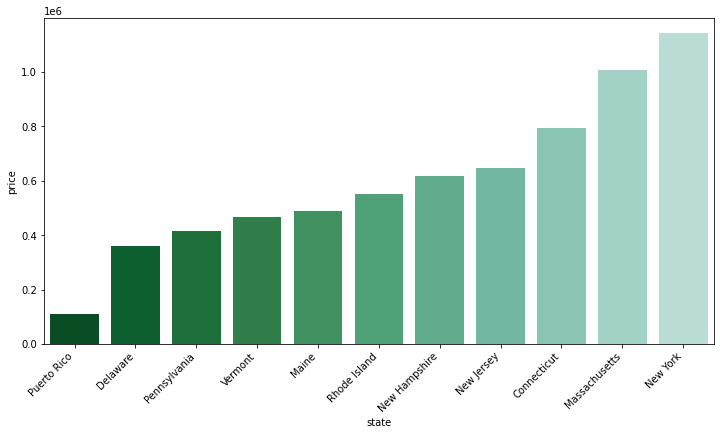

In [29]:
state_prices = df[['state','price']].groupby('state').mean().sort_values(by='price')
fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(x=state_prices.index, y=state_prices['price'], palette=sns.color_palette("BuGn_r", n_colors=len(state_prices) + 4), ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show()

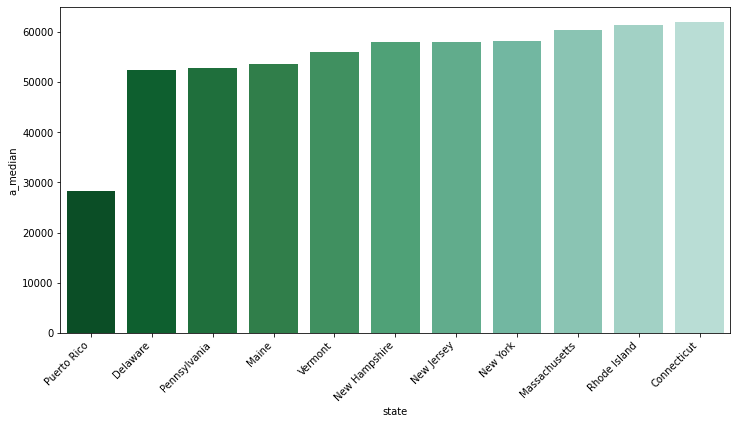

In [30]:
state_prices = df[['state','a_median']].groupby('state').mean().sort_values(by='a_median')
fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(x=state_prices.index, y=state_prices['a_median'], palette=sns.color_palette("BuGn_r", n_colors=len(state_prices) + 4), ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show()

### Looks like there is some correlation between housing cost and median wages, though not exact. Hopefully the percentiles give some distinction

In [31]:
freq_df.head(5)

,price,bed,bath,acre_lot,city,state,zip_code,house_size,sold_date
0,110000.0,7.0,3.0,0.09,1,1,1,1192.0,1.561680e+09
1,525000.0,3.0,3.0,0.45,8,3307,4,2314.0,1.403654e+09
2,289900.0,3.0,2.0,0.36,8,3307,4,1276.0,1.350000e+09
3,384900.0,3.0,2.0,0.46,8,3307,4,1476.0,5.328288e+08
4,199999.0,3.0,2.0,1.76,8,3307,4,1968.0,1.221782e+09


In [32]:
hashed_df.head(5)

,price,bed,bath,acre_lot,house_size,sold_date,zip_code1,zip_code2,zip_code3,zip_code4,...,zip_code16,zip_code17,zip_code18,zip_code19,zip_code20,zip_code21,zip_code22,zip_code23,zip_code24,zip_code25
0,110000.0,7.0,3.0,0.09,1192.0,1.561680e+09,0.0,0.0,0.0,-1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,-1.0,0.0,0.0
1,525000.0,3.0,3.0,0.45,2314.0,1.403654e+09,0.0,0.0,0.0,-1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,289900.0,3.0,2.0,0.36,1276.0,1.350000e+09,0.0,0.0,0.0,-1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,384900.0,3.0,2.0,0.46,1476.0,5.328288e+08,0.0,0.0,0.0,-1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,199999.0,3.0,2.0,1.76,1968.0,1.221782e+09,0.0,0.0,0.0,-1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [33]:
from min_max_scaler import MinMaxScaler

from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor

from pprint import pprint

def calc_rsme(x, y):
    return np.sqrt(np.sum((x-y)**2)/len(y))

def train_model(model, params, df_grid, feature, grid=False):
    scores = {}
    for df_name in df_grid.keys():
        print(f'training on {df_name}')
        df = df_grid[df_name]
        scores[df_name] = {}
        
        X = df.drop(feature, axis=1).values
        y = df[feature].values

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
        
        # turn off negative scaling since there is no concept of negative in our features
        mms = MinMaxScaler(negative_scale=False)
        X_train = mms.fit_transform(X_train)
        X_test = mms.transform(X_test)

        if grid:
            search = GridSearchCV(model, scoring='neg_root_mean_squared_error', cv=10, # neg_root_mean_squared_error
                                     param_grid=params, refit=True, n_jobs=-1)
        else:
            # np.prod produces 1 for empty list.
            max_iter = np.prod([len(val) for val in params.values()])

            if max_iter < 12:
                iters = max_iter
            else:
                iters = 12

            search = RandomizedSearchCV(model, scoring='neg_root_mean_squared_error', cv=10,
                                        n_iter=iters, param_distributions=params,
                                        refit=True, n_jobs=-1)
        
        search.fit(X_train, y_train)

        best_model = search.best_estimator_
        
        # negative since the RandomizedSearchCV uses negative root mean squared error
        best_params = search.best_params_
        preds = best_model.predict(X_test)
        rsme = calc_rsme(preds, y_test)
        
        scores[df_name]['rsme'] = rsme
        scores[df_name]['r2_test'] = best_model.score(X_test, y_test)
        scores[df_name]['r2_train'] = best_model.score(X_train, y_train)
        scores[df_name]['params'] = best_params
        
        print(f'done training on {df_name}')

    return scores

In [34]:
df_grid = { 'hashed_features': hashed_df, 'frequency_features': freq_df,
              'hashed_features_salary': hashed_df_sal, 'frequency_features_salary': freq_df_sal}

In [35]:
params = { 'positive': [True, False] }
scores = train_model(LinearRegression(), params, df_grid, 'price', grid=True)
pprint(scores)

training on hashed_features
done training on hashed_features
training on frequency_features
done training on frequency_features
training on hashed_features_salary
done training on hashed_features_salary
training on frequency_features_salary
done training on frequency_features_salary
{'frequency_features': {'params': {'positive': False},
                        'r2_test': 0.36609803555112386,
                        'r2_train': 0.3473891500822648,
                        'rsme': 1014018.2114553393},
 'frequency_features_salary': {'params': {'positive': False},
                               'r2_test': 0.28423761028492156,
                               'r2_train': 0.3873752318467554,
                               'rsme': 1244517.0172269165},
 'hashed_features': {'params': {'positive': False},
                     'r2_test': 0.355299605922196,
                     'r2_train': 0.35231500056016374,
                     'rsme': 1074057.3420470958},
 'hashed_features_salary': {'params': {'p

### Linear model does not perform well, need to go non-linear. Let's try some non-linear models.

In [36]:
params = {'n_neighbors': [2,5,10,15,20], 'weights': ['distance', 'uniform'], 'p': [1,2]}
scores = train_model(KNeighborsRegressor(), params, df_grid, 'price')
pprint(scores)

training on hashed_features
done training on hashed_features
training on frequency_features
done training on frequency_features
training on hashed_features_salary
done training on hashed_features_salary
training on frequency_features_salary
done training on frequency_features_salary
{'frequency_features': {'params': {'n_neighbors': 20,
                                   'p': 1,
                                   'weights': 'distance'},
                        'r2_test': 0.5326262650739744,
                        'r2_train': 0.9999998165074797,
                        'rsme': 815755.1010925589},
 'frequency_features_salary': {'params': {'n_neighbors': 20,
                                          'p': 1,
                                          'weights': 'distance'},
                               'r2_test': 0.626576285400354,
                               'r2_train': 0.9999994915199586,
                               'rsme': 713254.1129809439},
 'hashed_features': {'params': {'n_ne

In [37]:
# After several attempts we see it goes full pure ~30 nodes
params = {'splitter': ['best', 'random'], 'min_samples_split': [2, 20, 30, 40, 60], 'max_depth': [None,10,20]}
scores = train_model(DecisionTreeRegressor(), params, df_grid, 'price', grid=True)
pprint(scores)

training on hashed_features
done training on hashed_features
training on frequency_features
done training on frequency_features
training on hashed_features_salary
done training on hashed_features_salary
training on frequency_features_salary
done training on frequency_features_salary
{'frequency_features': {'params': {'max_depth': 20,
                                   'min_samples_split': 40,
                                   'splitter': 'random'},
                        'r2_test': 0.4455368476701752,
                        'r2_train': 0.5429092223878358,
                        'rsme': 914602.6140426834},
 'frequency_features_salary': {'params': {'max_depth': None,
                                          'min_samples_split': 20,
                                          'splitter': 'random'},
                               'r2_test': 0.21161257077439677,
                               'r2_train': 0.6982621432455305,
                               'rsme': 1239057.4376783231},
 'ha

In [38]:
# this one takes some time to train
params = {'n_estimators': [10,50,100], 'max_depth': [None,10,20], 'ccp_alpha': [0.01, 0.02, 0.03]}
scores = train_model(RandomForestRegressor(), params, df_grid, 'price')
pprint(scores)

training on hashed_features
done training on hashed_features
training on frequency_features
done training on frequency_features
training on hashed_features_salary
done training on hashed_features_salary
training on frequency_features_salary
done training on frequency_features_salary
{'frequency_features': {'params': {'ccp_alpha': 0.03,
                                   'max_depth': 20,
                                   'n_estimators': 100},
                        'r2_test': 0.49624451434105643,
                        'r2_train': 0.9369550520253791,
                        'rsme': 1026838.0380584172},
 'frequency_features_salary': {'params': {'ccp_alpha': 0.02,
                                          'max_depth': None,
                                          'n_estimators': 100},
                               'r2_test': 0.5902312608782201,
                               'r2_train': 0.9371527620063824,
                               'rsme': 707716.6338818505},
 'hashed_features'

In [39]:
# eta is learning rate
params = {'eta': [0.05,0.1,0.15], 'gamma': [0, 1, 10], 'max_depth': [3, 6, 10], 'lambda': [1,5,10]}
scores = train_model(XGBRegressor(), params, df_grid, 'price')
pprint(scores)

training on hashed_features
done training on hashed_features
training on frequency_features
done training on frequency_features
training on hashed_features_salary
done training on hashed_features_salary
training on frequency_features_salary
done training on frequency_features_salary
{'frequency_features': {'params': {'eta': 0.15,
                                   'gamma': 10,
                                   'lambda': 1,
                                   'max_depth': 3},
                        'r2_test': 0.46742854736727213,
                        'r2_train': 0.7338921910146194,
                        'rsme': 947569.5813690329},
 'frequency_features_salary': {'params': {'eta': 0.15,
                                          'gamma': 1,
                                          'lambda': 5,
                                          'max_depth': 6},
                               'r2_test': 0.5464174463041137,
                               'r2_train': 0.8656197479255963,
        

# Analysis
### Feature Engineering
1. Hashing the zip code feature did not add increased performance over simple frequency mapping on almost every model, except for gradient boosting. Furthermore, the additional complexity caused this feature set to take a much longer time to train the models. If scaled up to more data, it would not perform well.

2. Although not shown in the analysis above due to the time it took to train each model, it was tested to see if dropping NA values for bed, bath, and house_size was better than imputing, and imputing outperformed the dropped dataset every single time, therefore the imputed dataset was used

3. Adding the salary information had mixed results, on some models it performed better and some models it performed worse. This may indicate that this set is heavily reliant on which samples end up in the training set vs the test set.

### Results
KNeighbours on hashed_feature dataset performed the best overall, with the following parameters and scores:

```
    'hashed_features': {'params': {'n_neighbors': 10,
                                'p': 2,
                                'weights': 'distance'},
                     'r2_test': 0.5544254367940753,
                     'r2_train': 0.9999994724902049,
                     'rsme': 764905.7917151012},
```

XGBoost performed the second best on the hashed_feature with salary information dataset with the following parameters and scores:
```
    'hashed_features_salary': {'params': {'eta': 0.1,
                               'gamma': 0,
                               'lambda': 5,
                               'max_depth': 6},
                    'r2_test': 0.5865440127694885,
                    'r2_train': 0.7967384231241539,
                    'rsme': 768695.4941086745}}
```

The fact that KNeighbours performed the *worst* on the hashed feature with salary information shows that salaries that are near to one another are not necessarily indicative of the cost of a home, as this would add fake "similarities" where the median salaries were similar, but hurt the score of the model itself.

### Dataset Overview
Overall, it seems the features in this dataset are not predictive of the cost of a home. Since housing prices are not stationary (have high concept drift), housing datasets with long time periods like this may be difficult to predict off of. Furthermore, the prices vary wildly depending on where they were purchased, but will have nearly identical features otherwise. In this way, finding a better feature representation of the zip code for where the home was purchased *may* increase to improved prediction accuracy. However some zip codes may still span over areas where there are cheap homes and expensive homes and may not be a pure indicator.

To get better results, other datasets may need to be worked in with extra information about the zip codes (or cities), such as population, main industry (tech, agriculture, etc), may be helpful.